In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LassoCV

from sklearn.feature_selection import SelectFromModel

from sklearn.utils import resample, class_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
feature_names = pd.read_csv("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/feature_names.csv", header = None)

train_X =  pd.read_csv("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/train_X.csv", header = None)
train_Y =  pd.read_csv("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/train_Y.csv", header = None)
test_X =  pd.read_csv("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/test_X.csv", header = None)
test_Y =  pd.read_csv("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/test_Y.csv", header = None)

In [ ]:
train_data = pd.DataFrame(columns=['Feature_' + str(i) for i in range(1, 113)])

# Read each line from train_X.csv and update the corresponding feature columns
with open("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/train_X.csv", 'r') as file:
    for line in file:
        values = line.strip().split(',')
        instance_idx = int(values[0])  # Extract instance index
        feature_idx = int(values[1]) - 1  # Convert feature index to 0-based
        train_data.at[instance_idx, 'Feature_' + str(feature_idx + 1)] = int(values[2])

# Set Column Names
feature_names = pd.read_csv("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/feature_names.csv", header=None)
train_data.columns = feature_names[0].tolist()

In [ ]:
test_data = pd.DataFrame(columns=['Feature_' + str(i) for i in range(1, 113)])

# Read each line from train_X.csv and update the corresponding feature columns
with open("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/test_X.csv", 'r') as file:
    for line in file:
        values = line.strip().split(',')
        instance_idx = int(values[0])  # Extract instance index
        feature_idx = int(values[1]) - 1  # Convert feature index to 0-based
        test_data.at[instance_idx, 'Feature_' + str(feature_idx + 1)] = int(values[2])

# Set Column Names
feature_names = pd.read_csv("/content/drive/MyDrive/ELEG817-Large scale ML/HW/HW2/feature_names.csv", header=None)
test_data.columns = feature_names[0].tolist()

In [ ]:
train_data.shape

(8124, 112)

In [ ]:
test_data.shape

(200, 112)

In [ ]:
train_data = train_data.fillna(0)

In [ ]:
test_data = test_data.fillna(0)

For edible and poisonous mushrooms, we should assign a higher weight to the "poisonous" class.
The weight can be set based on prior  knowledge or trying different weight values to find the best trade-off to minimize false positives and false negatives.

Let's start by assigning a weight of 5 to the "poisonous" class and 1 to the "edible" class. This means that the classifier will pay more attention to correctly classifying poisonous mushrooms, even if it results in more false positives.


In [ ]:
class_weights = {1: 1.0, -1: 5.0}

    Splitting the Traing Data:
        The ince the eoriginal ddata has already been split into two, I will further split the training data into to three parts:
        the training set, the validation set (from training), and the test set.
        The training set will be used to train the models.
        The validation set will be used to select hyperparameters and assess the model's performance during the tuning process.
        The test set will evaluate the final model's generalization performance.

    Metric:
        Common weighted metrics include accuracy and F1-score

    Hyperparameter Tuning:
        Choosing a range of hyperparameters to tune, such as regularization parameters (L1, L2, and elasticnet)
        Picking 5-fold cross validation, to tune these hyperparameters on the training set.

    Grid Search or Random Search:
        Grid search evaluates all possible combinations of hyperparameters in a specified range, while random search samples from this space randomly, I'll use grid search.

    Convex Minimization:
        Convex minimization is not a strict requirement. Even non-convex optimization can work well for many problems when combined with careful hyperparameter selection.

    Selecting the Best Hyperparameters:
        Choosing the hyperparameter combination that resulted in the best performance on the weighted validation metric during the cross-validation process.

    Model Evaluation on the Test Set:
        Finally, evaluate the model's performance on the test set, which haven't used during training or hyperparameter tuning. This step provides an unbiased estimate of the model's generalization performance.

In [ ]:
# Data is stored in 'merged_data'
X = train_data
y = np.ravel(train_Y)

# Convert X and y to np arrays
X = X.to_numpy()

In [ ]:
# Test data
X_testing = test_data  # Select the first 112 columns as features X
y_testing = np.ravel(test_Y)

# Convert X and y to np arrays
X_testing = X_testing.to_numpy()

In [ ]:
# Split data into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

The Loss function is a logistic regression, and I'll use a the L2 regularization to address the colinearity of the of the variance

In [ ]:
# Create a logistic regression model with class weights
model1 = LogisticRegression(class_weight= class_weights, max_iter= 1000, penalty = 'l2', solver = 'liblinear', C = 1.0)

# Train the model on your training data
model1.fit(X_train, y_train)

LogisticRegression(class_weight={-1: 5.0, 1: 1.0}, max_iter=1000,
                   solver='liblinear')

Elasticnet not inlcuded, since i could not get it to converge

In [ ]:
# Define hyperparameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2']}

# Use Grid Search with cross-validation
grid_search = GridSearchCV(model1, param_grid, cv=5)

# Fit the model to training data
grid_search.fit(X_val, y_val)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [ ]:
best_params

{'C': 1, 'penalty': 'l1'}

In [ ]:
# Make predictions on the test set
y_pred_test = model1.predict(X_testing)

# Evaluate the model's performance
accuracy = accuracy_score(y_testing, y_pred_test)
precision = precision_score(y_testing, y_pred_test)
recall = recall_score(y_testing, y_pred_test)
f1 = f1_score(y_testing, y_pred_test)
conf_matrix = confusion_matrix(y_testing, y_pred_test)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.54
Precision: 0.5285714285714286
Recall: 0.3854166666666667
F1 Score: 0.44578313253012053
Confusion Matrix:
 [[71 33]
 [59 37]]


The next model is using the result of the hyperparameter tuning

In [ ]:
# Create a logistic regression model with class weights.
model1_best_params = LogisticRegression(class_weight= class_weights, max_iter=1000, penalty = 'l1', solver = 'liblinear', C = 1.0)

# Train the model on your training data
model1_best_params.fit(X_train, y_train)

LogisticRegression(class_weight={-1: 5.0, 1: 1.0}, max_iter=1000, penalty='l1',
                   solver='liblinear')

In [ ]:
# Make predictions on the validation set
y_pred = model1_best_params.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7532307692307693
Precision: 0.8823529411764706
Recall: 0.604982206405694
F1 Score: 0.7178043631245602
Confusion Matrix:
 [[714  68]
 [333 510]]


In [ ]:
# Make predictions on the test set
y_pred_test = model1_best_params.predict(X_testing)

# Evaluate the model's performance
accuracy = accuracy_score(y_testing, y_pred_test)
precision = precision_score(y_testing, y_pred_test)
recall = recall_score(y_testing, y_pred_test)
f1 = f1_score(y_testing, y_pred_test)
conf_matrix = confusion_matrix(y_testing, y_pred_test)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.545
Precision: 0.5342465753424658
Recall: 0.40625
F1 Score: 0.46153846153846156
Confusion Matrix:
 [[70 34]
 [57 39]]


In [ ]:
# Train a Lasso model for feature selection
lasso_model = LassoCV(cv=5)  # Use cross-validation to select the best alpha
lasso_model.fit(X_train, y_train)

LassoCV(cv=5)

In [ ]:
# Select features based on non-zero coefficients
selected_features = SelectFromModel(lasso_model, prefit=True).get_support()

# Train logistic regression model on the selected features
model_2 = LogisticRegression(class_weight= class_weights, max_iter=1000, solver='liblinear')
model_2.fit(X_train[:, selected_features], y_train)

# Get feature names and coefficients
feature_names = train_data.columns

selected_feature_names = feature_names[selected_features]

coefficients = model_2.coef_[0]

# Sort features by coefficient value (in descending order)
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
selected_feature_names = selected_feature_names[sorted_indices]
coefficients = coefficients[sorted_indices]

# Report the selected features and their coefficients
for feature, coef in zip(selected_feature_names, coefficients):
    print(f"Feature: {feature}, Coefficient: {coef:.4f}")

# Size of the support for relevant features
support_size = np.sum(selected_features)
print(f"Support size: {support_size}")

Feature: cap-shape=bell, Coefficient: 2.6986
Feature: cap-shape=flat, Coefficient: 2.3394
Feature: spore-print-color=chocolate, Coefficient: 1.1943
Feature: cap-shape=convex, Coefficient: -0.7528
Feature: odor=creosote, Coefficient: -0.6898
Feature: bruises?=no, Coefficient: -0.6627
Feature: odor=none, Coefficient: 0.5296
Feature: spore-print-color=white, Coefficient: 0.4258
Feature: stalk-color-above-ring=gray, Coefficient: -0.3709
Feature: odor=foul, Coefficient: -0.3374
Feature: habitat=grasses, Coefficient: 0.2540
Feature: cap-color=yellow, Coefficient: 0.2522
Feature: gill-size=broad, Coefficient: -0.1598
Feature: habitat=paths, Coefficient: 0.1552
Feature: stalk-surface-below-ring=smooth, Coefficient: -0.1489
Feature: stalk-surface-above-ring=fibrous, Coefficient: 0.1489
Feature: stalk-surface-below-ring=fibrous, Coefficient: 0.1488
Feature: population=scattered, Coefficient: -0.1053
Feature: gill-color=gray, Coefficient: -0.1004
Feature: population=solitary, Coefficient: -0.0519

In [ ]:
# Define hyperparameter grid
param_grid_2 = {'C': [0.001, 0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2']}

# Use Grid Search with cross-validation
grid_search_2 = GridSearchCV(model_2, param_grid, cv=5)

# Fit the model to training data
grid_search_2.fit(X_val[:, selected_features], y_val)

# Get the best hyperparameters
best_params_2 = grid_search_2.best_params_

In [ ]:
print(best_params_2)

{'C': 1, 'penalty': 'l1'}


In [ ]:
# Make predictions on the validation set
y_pred = model_2.predict(X_val[:,selected_features])

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7563076923076923
Precision: 0.882051282051282
Recall: 0.6120996441281139
F1 Score: 0.7226890756302521
Confusion Matrix:
 [[713  69]
 [327 516]]


In [ ]:
# Make predictions on the test set
y_pred_test = model_2.predict(X_testing[:, selected_features])

# Evaluate the model's performance
accuracy = accuracy_score(y_testing, y_pred_test)
precision = precision_score(y_testing, y_pred_test)
recall = recall_score(y_testing, y_pred_test)
f1 = f1_score(y_testing, y_pred_test)
conf_matrix = confusion_matrix(y_testing, y_pred_test)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.565
Precision: 0.5616438356164384
Recall: 0.4270833333333333
F1 Score: 0.485207100591716
Confusion Matrix:
 [[72 32]
 [55 41]]


BoLasso

In [ ]:
n_bootstraps = 100  # Number of bootstrap samples
alpha_values = np.logspace(-4, 4, 100)  # Range of alpha values for LassoCV

selected_features_boot = None  # To store the common selected features

for _ in range(n_bootstraps):
    # Generate a bootstrap sample
    X_bootstrap, y_bootstrap = resample(X, y, random_state=np.random.randint(0, 1000))

    # Fit Lasso model with cross-validation to select the best alpha
    bolasso_model = LassoCV(alphas=alpha_values, cv=5, max_iter = 3000)
    bolasso_model.fit(X_bootstrap, y_bootstrap)

    # Get the selected features based on the best alpha
    selected = np.abs(bolasso_model.coef_) > 1e-7  # Choose a threshold

    # If it's the first iteration, initialize selected_features
    if selected_features_boot is None:
        selected_features_boot = selected
    else:
        # Update selected_features by taking the intersection with the new selected features
        # Update the selected features by computing the intersection
        selected_features_boot = selected_features_boot & selected

# Extract the feature coefficients for the common features
w_hat_J = bolasso_model.coef_[selected_features_boot]

# Print the coefficients and their corresponding feature names
selected_feature_names = feature_names[selected_features_boot]

for feature, coef in zip(selected_feature_names, w_hat_J):
    print(f"Feature: {feature}, Coefficient: {coef:.4f}")

print(f"Number of selected features: {selected_features_boot.sum()}")

Feature: cap-shape=bell, Coefficient: 1.0903
Feature: cap-shape=flat, Coefficient: 1.0727
Feature: cap-shape=convex, Coefficient: -0.1634
Feature: spore-print-color=chocolate, Coefficient: 0.1744
Feature: spore-print-color=white, Coefficient: 0.2323
Number of selected features: 5


In [ ]:
X_final = X[:, selected_features_boot]

In [ ]:
# Train a Lasso model for feature selection
Bolasso_model_feature_selection = LassoCV(cv=5)
Bolasso_model_feature_selection.fit(X_final, y)

LassoCV(cv=5)

In [ ]:
# Make predictions on the validation set
y_pred = Bolasso_model_feature_selection.predict(X_val[:, selected_features_boot])

In [ ]:
print(y_pred)

[ 0.60551352 -0.46075633 -0.46075633 ... -0.46075633 -0.46075633
  0.60551352]


In [ ]:
# Train logistic regression model on the bootstrapeed selected features
model_3 = LogisticRegression(class_weight= class_weights, max_iter=1000, penalty='l1', solver = 'liblinear', C = 1.0)
model_3.fit(X_final, y)

LogisticRegression(class_weight={-1: 5.0, 1: 1.0}, max_iter=1000, penalty='l1',
                   solver='liblinear')

In [ ]:
# Make predictions on the validation set
y_pred = model_3.predict(X_val[:, selected_features_boot])

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7993846153846154
Precision: 0.8488529014844804
Recall: 0.7461447212336892
F1 Score: 0.7941919191919191
Confusion Matrix:
 [[670 112]
 [214 629]]


In [ ]:
# Make predictions on the test set
y_pred_test = model_3.predict(X_testing[:, selected_features_boot])

# Evaluate the model's performance
accuracy = accuracy_score(y_testing, y_pred_test)
precision = precision_score(y_testing, y_pred_test)
recall = recall_score(y_testing, y_pred_test)
f1 = f1_score(y_testing, y_pred_test)
conf_matrix = confusion_matrix(y_testing, y_pred_test)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.55
Precision: 0.5340909090909091
Recall: 0.4895833333333333
F1 Score: 0.5108695652173912
Confusion Matrix:
 [[63 41]
 [49 47]]


5) Compare the two models by making a scatter plot where the x-coordinate of each point is the
coefficient for a feature using the first classifier and the y-coordinate of the point is the coefficient
value for the second classifier (noting that some of the coefficients for the second classifier will be
exactly zero if there was feature selection)

In [ ]:
# Create an array of zeros with the same shape as bolasso_coefficients
zero_padding = np.zeros(abs(len(model_2.coef_.flatten())-len(model1.coef_.flatten())))

# Append the zero_padding to the end of bolasso_coefficients
lasso_with_zeros = np.append(model_2.coef_, zero_padding)

In [ ]:
coefficients_model1 = model1.coef_.flatten()
coefficients_model2 = lasso_with_zeros

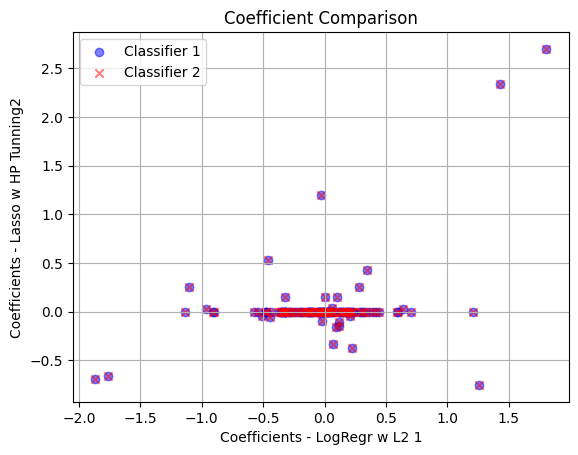

In [ ]:
# Create a scatter plot with different shapes and colors
plt.scatter(coefficients_model1, coefficients_model2, alpha=0.5, c='b', marker='o', label='Classifier 1')
plt.scatter(coefficients_model1, coefficients_model2, alpha=0.5, c='r', marker='x', label='Classifier 2')

plt.xlabel("Coefficients - LogRegr w L2 1")
plt.ylabel("Coefficients - Lasso w HP Tunning2")
plt.title("Coefficient Comparison")

# Show or save the plot
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Create an array of zeros with the same shape as bolasso_coefficients
zeros = np.zeros(abs(len(Bolasso_model_feature_selection.coef_)-len(model1.coef_.flatten())))

# Append the zero_padding to the end of bolasso_coefficients
bolasso_coefficients_with_zeros = np.append(Bolasso_model_feature_selection.coef_, zeros)

In [ ]:
coefficients_model1 = model1.coef_.flatten()
coefficients_model2 = bolasso_coefficients_with_zeros

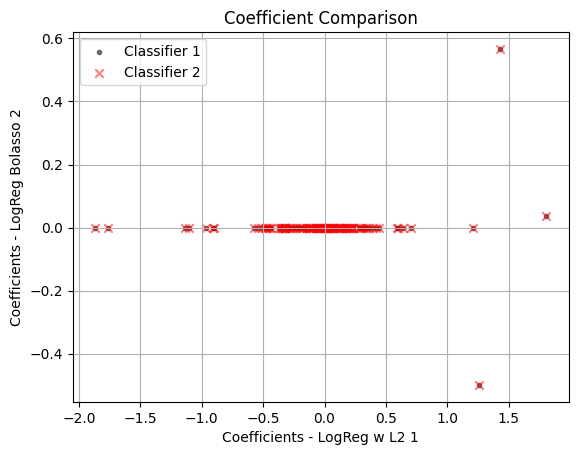

In [ ]:
# Create a scatter plot with different shapes and colors
plt.scatter(coefficients_model1, coefficients_model2, alpha=0.5, c='k', marker='.', label='Classifier 1')
plt.scatter(coefficients_model1, coefficients_model2, alpha=0.5, c='r', marker='x', label='Classifier 2')

plt.xlabel("Coefficients - LogReg w L2 1")
plt.ylabel("Coefficients - LogReg Bolasso 2")
plt.title("Coefficient Comparison")

# Show or save the plot
plt.legend()
plt.grid()
plt.show()

For a non-linear classifier using a kernel support vector machine (SVM), you can choose the following design choices:

Model and Loss Function:
Model: Kernel Support Vector Machine (SVM)
Loss Function: Hinge loss is typically used for SVM. It encourages the correct classification of data points and maximizes the margin between the support vectors.

Regularization:
SVM inherently includes regularization by introducing a penalty term for misclassification and controlling the margin. The regularization parameter is typically denoted as 'C' in SVM. A smaller 'C' encourages a larger margin but allows some misclassification, while a larger 'C' penalizes misclassification more heavily. You can choose 'C' based on cross-validation or validation performance.

Kernel Function:

SVM allows to choose different kernel functions to model non-linear decision boundaries.
            
Radial Basis Function (RBF) Kernel: Suitable for capturing complex non-linear decision boundaries.

Polynomial Kernel: Suitable for data with polynomial structures.

Sigmoid Kernel: Suitable for data with sigmoid-like decision boundaries.

Hyperparameter Tuning:
Perform hyperparameter tuning to select the optimal values for 'C' and kernel-specific hyperparameters (e.g., gamma for RBF kernel or degree for polynomial kernel).
Use techniques like cross-validation or grid search to find the best hyperparameters that maximize the model's performance on a validation set.

Feature Scaling:
SVM is sensitive to the scale of features, so it's a good practice to perform feature scaling (e.g., standardization) to ensure that all features contribute equally to the decision boundary.

In [ ]:
# Perform feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the SVM model with RBF kernel
svm_classifier = SVC(kernel='sigmoid', class_weight = class_weights)

# Define hyperparameters for tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1]
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5)
grid_search.fit(X_scaled, y)

# Get the best parameters and best model
best_params_svm = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

In [ ]:
best_params_svm

{'C': 1, 'gamma': 0.01}

In [ ]:
best_svm_model

SVC(C=1, class_weight={-1: 5.0, 1: 1.0}, gamma=0.01, kernel='sigmoid')

In [ ]:
# Perform feature scaling on the test data
X_testing_scaled = scaler.transform(X_testing)

# Use the best SVM model to make predictions
y_pred_test = best_svm_model.predict(X_testing_scaled)

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_testing, y_pred_test)
precision = precision_score(y_testing, y_pred_test)
recall = recall_score(y_testing, y_pred_test)
f1 = f1_score(y_testing, y_pred_test)
conf_matrix = confusion_matrix(y_testing, y_pred_test)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.54
Precision: 0.5370370370370371
Recall: 0.3020833333333333
F1 Score: 0.38666666666666666
Confusion Matrix:
 [[79 25]
 [67 29]]


Finally, to evaluate your three final classifiers (linear without feature selection, linear with feature
selection, and non-linear) report the correspondence of each predictions on the test set to the true
values using a confusion matrix (results will be three 2-by-2 matrices).

Logitic Regression with HP tunning:
Confusion Matrix:
\begin{align}
        \begin{pmatrix}
         70 & 34 \\
         57 & 39
        \end{pmatrix}.
\end{align}


Logistic Regression with Lasso:
Confusion Matrix:
\begin{align}
        \begin{pmatrix}
         72 & 32 \\
         55 & 41
        \end{pmatrix}.
\end{align}

Logistic Regrssion with Bolasso:
Confusion Matrix:
\begin{align}
        \begin{pmatrix}
         63 & 41 \\
         49 & 47
        \end{pmatrix}.
\end{align}

SVM:
Confusion Matrix:
\begin{align}
        \begin{pmatrix}
         79 & 25 \\
         67 & 29
        \end{pmatrix}.
\end{align}

Using, logistic regression with L2 regularization, Lasso feature selection with logistic regression, and BoLasso were used for classification, and Support Vector Machines with Sigmoid kernel were tested.

These models were evaluated based on accuracy, precision, recall, and F1 score, and confussion matrix to assess their classification capabilities.

The results indicated that all three models achieved relatively high accuracy, suggesting their effectiveness in distinguishing between edible and poisonous mushrooms.

The logistic regression model demonstrated strong performance, which can be attributed to its linear nature and ability to capture simple decision boundaries.

The Lasso feature selection with logistic regression showed that feature selection based on Lasso regularization could help improve model interpretability and reduce overfitting.

The BoLasso method significantly reduced the number of features and refined the feature selection process by adding results from multiple bootstrap samples, this provided a simple but effective classifcation combined with Logistic regression.

However, there are certain limitations that need to be addressed.

All the models' performance might not generalize well to unseen data, and that can be seen when using the testing data set as all classifier models did not achieve any metric above 60%

Additionally, the choice of class weights, regularization parameters, and feature selection thresholds could affect the models' performance and would ideally require further fine-tuning.

So the results suggest that the chosen models can effectively classify mushrooms as edible or poisonous. However, to ensure reliable performance on real-world data, additional data, more careful hyperparameter tuning, and cross-validation are necessary.
Also, the models' interpretability and transparency may be further enhanced by selecting the most informative features, potentially reducing the risk of false positives in the classification of poisonous mushrooms.